<a href="https://colab.research.google.com/github/mx-mn/image-reconstruction-cv23/blob/main/code/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, Add, Activation
from keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import math
from torch.utils.data import Dataset, DataLoader, TensorDataset
from pathlib import Path
import torch
from tqdm import tqdm
from collections import defaultdict
import os
import zipfile
import random
from datetime import datetime

print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import drive

drive.mount('/content/drive/')
cwd = Path().cwd()

moritz = "/content/drive/My Drive/Colab/CV23_Data/preprocessed_data/Datasets.zip"
david = "/content/drive/My Drive/CV23_Data/preprocessed_data/Datasets.zip"
maxi = cwd / 'drive' / 'My Drive' / 'cvue23' / 'Datasets.zip'

zip_ref = zipfile.ZipFile(maxi, 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

# magic to unzip file into temp
# !unzip path_to_file.zip -d path_to_directory

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
checkpoint_path = cwd / 'drive' / 'My Drive' / 'cvue23' / 'model_checkpoints'
checkpoint_path.mkdir(exist_ok=True)
datasets_path = cwd.parent.parent / 'tmp'

train_set_path = datasets_path / 'training_set'
val_set_original_path = datasets_path / 'validation_set_original'
val_set_crop_path = datasets_path / 'validation_set_cropped'

assert (train_set_path.exists() and val_set_original_path.exists() and val_set_crop_path.exists())

In [7]:
map_label_to_name = ['no_person', 'idle','sitting', 'laying']

class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        basedir: Path,
        batch_size: int = None,
        included_poses: list = None,
        included_trees: list = None,
        shuffle=False,
        only_use_n: int = None
    ):
        if not basedir.exists():
            ValueError('Datafolder does not exist. Add it to your drive and try again. Maybe restart the runtime.')

        self.basedir = basedir
        self.batch_size = batch_size
        self.included_poses = [map_label_to_name.index(pose) for pose in included_poses] if included_poses is not None else None
        self.included_trees  = included_trees
        self.filenames = self.__filter(shuffle, only_use_n)

    def __filter(self, shuffle, only_use_n):

        files = []
        self.pose_distribution = defaultdict(int)
        self.trees_distribution = defaultdict(int)
        self.pose_distribution_filtered = defaultdict(int)
        self.trees_distribution_filtered = defaultdict(int)

        unfiltered = list(self.basedir.iterdir())

        if shuffle:
            random.shuffle(unfiltered)

        total = len(unfiltered)
        if only_use_n is not None:
            total = only_use_n

        for path in tqdm(unfiltered, total=total):

            loaded = np.load(path)
            pose, trees = loaded['pose'], loaded['trees']

            self.pose_distribution[pose.item()] += 1
            self.trees_distribution[trees.item()] += 1

            fname = path.name
            if self.included_poses is not None and pose not in self.included_poses:
                continue

            if self.included_trees is not None and trees not in self.included_trees:
                continue

            files.append(fname)
            self.pose_distribution_filtered[pose.item()] += 1
            self.trees_distribution_filtered[trees.item()] += 1

            if only_use_n is not None and len(files) == only_use_n:
                break

        return files

    def load(self, path):
        loaded = np.load(path)
        x = loaded['x'] / 255
        y = loaded['y'] / 255
        return x, y

    def __len__(self):
        if self.batch_size is None:
            return len(self.filenames)

        return math.ceil(len(self.filenames) / self.batch_size)

    def __getitem__(self, idx):

        if self.batch_size is None:
            batch = self.filenames
        else:
            low = idx * self.batch_size
            high = min(low + self.batch_size, len(self.filenames))
            batch = self.filenames[low:high]

        X, Y = [],[]
        for fname in batch:
            x,y = self.load(self.basedir / fname)
            X.append(x)
            Y.append(y)

        return np.stack(X), np.stack(Y)

    def print_info(self):
        print()
        shape = self.load(self.basedir / self.filenames[0])[0].shape
        print(f'{len(self.filenames)} samples with shape : {shape}')

        print(f'Pose distribution total')
        ("{:<15} {:<15}".format('pose', 'number of samples'))
        for key, value in self.pose_distribution.items():
            print("{:<15} {:<15}".format(map_label_to_name[key], value))
        print()
        print(f'Pose distribution filtered')
        ("{:<15} {:<15}".format('pose', 'number of samples'))
        for key, value in self.pose_distribution_filtered.items():
            print("{:<15} {:<15}".format(map_label_to_name[key], value))

        print()
        print(f'Trees distribution total')
        print("{:<15} {:<15}".format('num trees per ha', 'number of samples'))

        for key, value in self.trees_distribution.items():
            print("{:<15} {:<15}".format(key, value))

        print()
        print(f'Trees distribution filtered')
        print("{:<15} {:<15}".format('num trees per ha', 'number of samples'))

        for key, value in self.trees_distribution_filtered.items():
            print("{:<15} {:<15}".format(key, value))


In [9]:
print('Training Dataset ')

train_data = DataGenerator(
    train_set_path,
    batch_size=64,
    included_poses=['idle','sitting', 'laying'],
    shuffle=True,
    only_use_n=1024,
)
train_data.print_info()

print('Validation Dataset ')
validation_data = DataGenerator(
    val_set_original_path,
    batch_size=16,
    included_poses=['idle','sitting', 'laying'],
    shuffle=True,
    only_use_n=128,
)
validation_data.print_info()

Training Dataset 


1138it [00:02, 431.09it/s]



1024 samples with shape : (128, 128, 6)
Pose distribution total
idle            341            
sitting         359            
laying          324            
no_person       115            

Pose distribution filtered
idle            341            
sitting         359            
laying          324            

Trees distribution total
num trees per ha number of samples
0               111            
100             672            
200             356            

Trees distribution filtered
num trees per ha number of samples
0               100            
100             601            
200             323            
Validation Dataset 


147it [00:00, 468.19it/s]                         


128 samples with shape : (512, 512, 6)
Pose distribution total
idle            47             
sitting         39             
laying          42             
no_person       20             

Pose distribution filtered
idle            47             
sitting         39             
laying          42             

Trees distribution total
num trees per ha number of samples
200             53             
100             76             
0               19             

Trees distribution filtered
num trees per ha number of samples
200             47             
100             65             
0               16             


In [10]:
val_set_size = 16
basedir = val_set_crop_path
include_poses=['idle','sitting', 'laying']
shuffle=True

validation_set_0_trees = DataGenerator(
    basedir,
    included_poses=include_poses,
    included_trees=[0],
    shuffle=shuffle,
    only_use_n=val_set_size
)
validation_set_0_trees.print_info()

validation_set_100_trees = DataGenerator(
    basedir,
    included_poses=include_poses,
    included_trees=[100],
    shuffle=shuffle,
    only_use_n=val_set_size
)
validation_set_100_trees.print_info()

validation_set_200_trees = DataGenerator(
    basedir,
    included_poses=include_poses,
    included_trees=[200],
    shuffle=shuffle,
    only_use_n=val_set_size
)
validation_set_200_trees.print_info()

153it [00:00, 342.02it/s]



16 samples with shape : (128, 128, 6)
Pose distribution total
laying          53             
no_person       18             
sitting         43             
idle            40             

Pose distribution filtered
sitting         9              
idle            3              
laying          4              

Trees distribution total
num trees per ha number of samples
100             89             
200             47             
0               18             

Trees distribution filtered
num trees per ha number of samples
0               16             


20it [00:00, 390.99it/s]              



16 samples with shape : (128, 128, 6)
Pose distribution total
sitting         7              
idle            6              
laying          8              

Pose distribution filtered
idle            5              
laying          6              
sitting         5              

Trees distribution total
num trees per ha number of samples
200             4              
100             16             
0               1              

Trees distribution filtered
num trees per ha number of samples
100             16             


38it [00:00, 350.88it/s]


16 samples with shape : (128, 128, 6)
Pose distribution total
sitting         16             
idle            11             
laying          9              
no_person       3              

Pose distribution filtered
sitting         9              
idle            3              
laying          4              

Trees distribution total
num trees per ha number of samples
100             19             
200             17             
0               3              

Trees distribution filtered
num trees per ha number of samples
200             16             


In [22]:
# for debugging
def plot_image_grid(images_array, grid_width=10, grid_height=10):

    if images_array.shape[0] != grid_width * grid_height:
        raise ValueError("The number of images does not match the grid size.")

    fig, axes = plt.subplots(grid_height, grid_width, figsize=(int(3*grid_width), int(3*grid_height)))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images_array[i], cmap='gray', interpolation='none')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def encoder(x, num_features, num_layers, residual_every=2):
    x = Conv2D(num_features, kernel_size=3, strides=2, padding='same', activation='relu')(x)

    # Save the output of conv layers at even indices
    residuals = []

    # Encoder
    for i in range(num_layers - 1):
        x = Conv2D(num_features, kernel_size=3, padding='same', activation='relu')(x)
        if (i + 1) % residual_every == 0:
            residuals.append(x)

    return x, residuals

def decoder(x, num_features, num_layers, residuals, residual_every=2):

    # Decoder
    for i in range(num_layers - 1):
        x = Conv2DTranspose(num_features, kernel_size=3, padding='same')(x)

        if (i + 1 + num_layers) % residual_every == 0 and residuals:
            res = residuals.pop()
            x = Add()([x, res])

        x = Activation('relu')(x)

    if residuals: raise ValueError('There are unused residual connections')

    # create 1-channel output
    x = Conv2DTranspose(1, kernel_size=3, strides=2, padding='same')(x)

    return x

def REDNet(num_layers, num_features, channel_size):
    '''Model definition with keras functional layers api'''

    inputs = Input(shape=(None, None, channel_size))

    x, residuals = encoder(inputs, num_features, num_layers)

    x = decoder(x, num_features, num_layers, residuals)

    # Add input residual, needed to do 1x1 conv to adapt channels
    residual = Conv2DTranspose(1, kernel_size=1, padding='same')(inputs)
    outputs = Add()([x, residual])
    outputs = Activation('relu')(outputs)

    # Create model
    model = Model(inputs=inputs, outputs=outputs, name=f'REDNet{num_layers*2}')
    return model

class PlotPredictionsCallback(Callback):
    def __init__(self, x, y, interval=1):
        super().__init__()
        self.interval = interval
        self.x, self.y = x, y

    def on_epoch_end(self, epoch, logs={}):
        if (epoch+1) % self.interval == 0 and epoch > 0:
            preds = self.model.predict_on_batch(self.x)
            for x, y, pred in zip(self.x, self.y, preds):
                z = np.concatenate([x, np.expand_dims(y, axis=-1), pred], axis=-1)
                plot_image_grid(z.T, z.shape[-1], 1)


class ExtraValidation(Callback):
    def __init__(self, x, y, name, interval=1):
        super().__init__()

        self.interval = interval
        self.x, self.y = x, y
        self.name = name

    def on_epoch_end(self, epoch, logs=None):
        # evaluate at an interval of `validation_freq` epochs
        if (epoch + 1) % self.interval == 0:
            # gather the evaluation metrics
            scores = self.model.evaluate(
                x=self.x,
                y=self.y,
                batch_size=self.x.shape[0],
                verbose=1
            )

            # add the validation loss to the logs dictionary
            logs[self.name] = scores

In [23]:
CHANNEL_SIZE = 6
NUM_LAYERS = 9
NUM_FEATURES = 64
LR = 0.0001

# compile the model
model = REDNet(
    num_layers=NUM_LAYERS,
    num_features=NUM_FEATURES,
    channel_size=CHANNEL_SIZE
)

opt = keras.optimizers.Adam(
    learning_rate=LR
)

loss = keras.losses.MeanSquaredError(
    reduction="sum_over_batch_size",
    name="mse"
)

model.compile(loss=loss,optimizer=opt)

In [24]:
n=2
x0, y0 = validation_set_0_trees[0]
x100, y100 = validation_set_100_trees[0]
x200, y200 = validation_set_200_trees[0]

x_plot = np.concatenate([x0[:n], x100[:n], x200[:n]], axis=0)
y_plot = np.concatenate([y0[:n], y100[:n], y200[:n]], axis=0)

In [25]:
filepath = checkpoint_path / f'{datetime.now().strftime("%Y%m%d-%H%M%S")}.model.keras'

callbacks = [
    ModelCheckpoint(filepath.as_posix(),save_best_only=True),
    PlotPredictionsCallback(interval=3, x=x_plot, y=y_plot),
    #EarlyStopping(patience=3),
    ExtraValidation(x0, y0, '0_trees', interval=1),
    ExtraValidation(x100, y100, '100_trees', interval=1),
    ExtraValidation(x200, y200, '200_trees', interval=1)
]

In [26]:
# csv_logger = CSVLogger(personal_drive / 'training.csv', append=True)

Epoch 1/5
 6/16 [==========>...................] - ETA: 2s - loss: 0.0738

16/16 [==============================] - 109s 6s/step - loss: 0.0603 - val_loss: 0.0514 - 0_trees: 0.0123 - 100_trees: 0.0595 - 200_trees: 0.0615
Epoch 2/5
16/16 [==============================] - 70s 4s/step - loss: 0.0485 - val_loss: 0.0472 - 0_trees: 0.0168 - 100_trees: 0.0591 - 200_trees: 0.0582
Epoch 3/5
16/16 [==============================] - ETA: 0s - loss: 0.0478

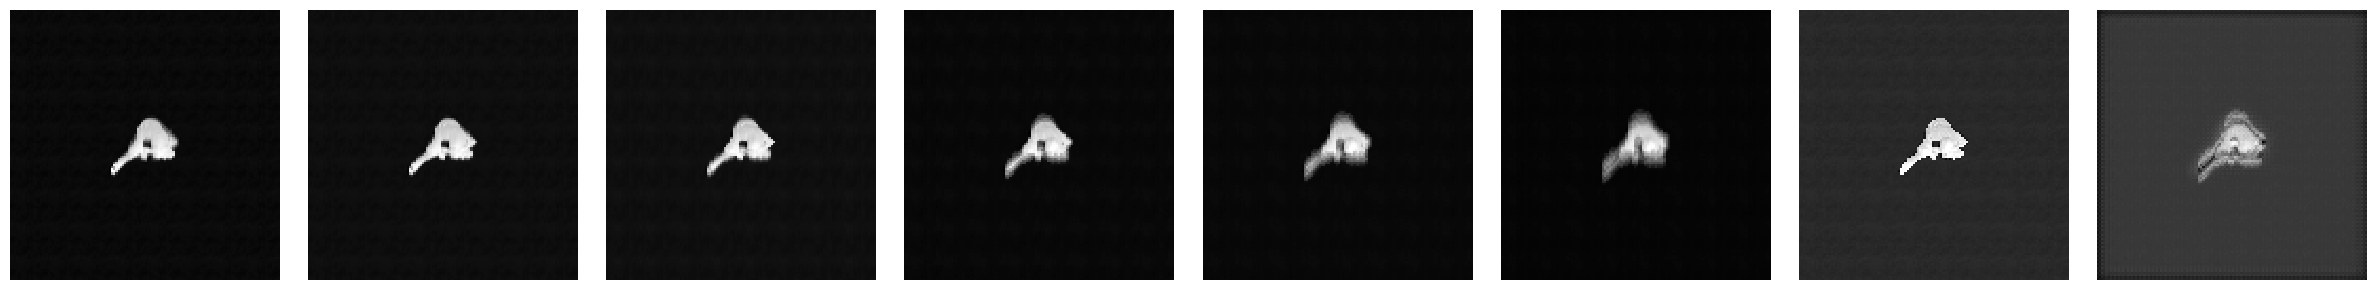

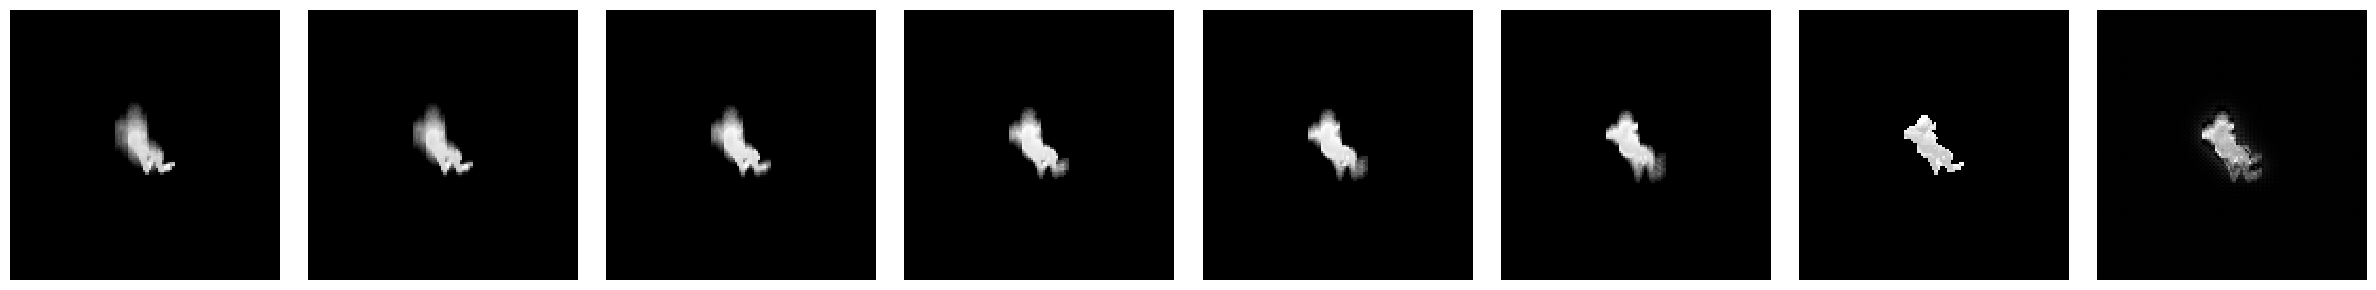

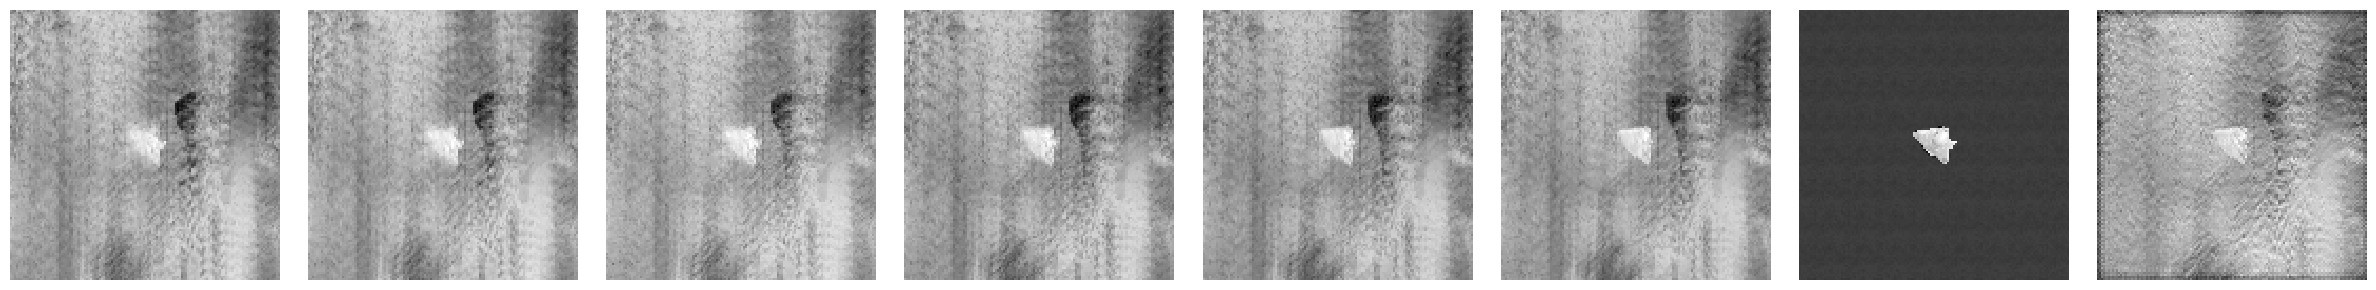

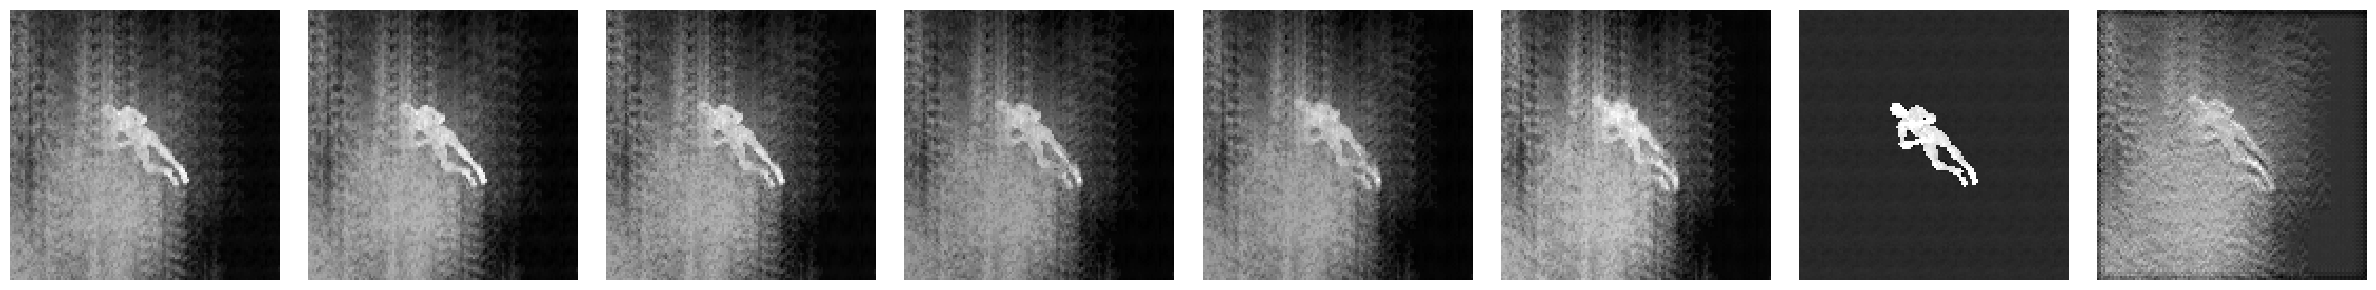

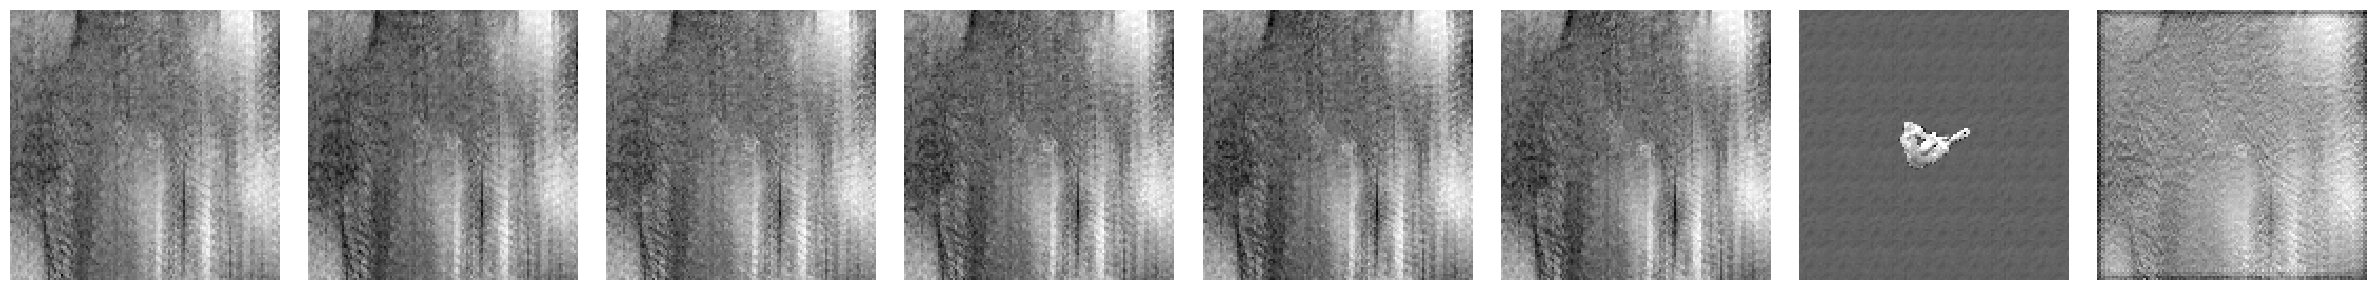

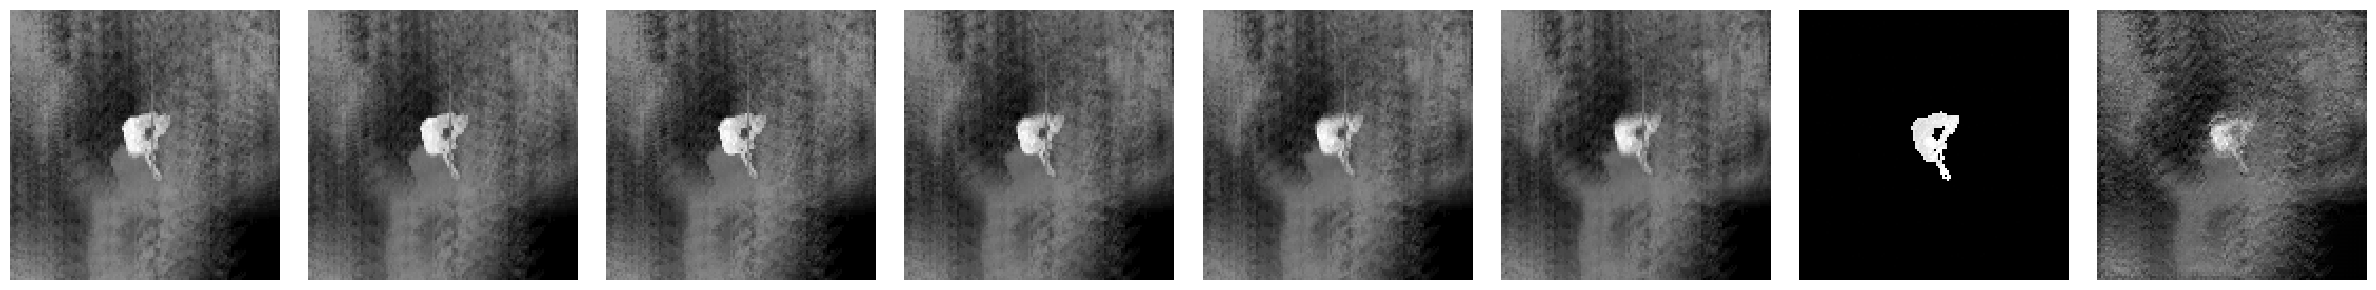

16/16 [==============================] - 91s 6s/step - loss: 0.0478 - val_loss: 0.0483 - 0_trees: 0.0133 - 100_trees: 0.0574 - 200_trees: 0.0583
Epoch 4/5
16/16 [==============================] - 72s 5s/step - loss: 0.0474 - val_loss: 0.0478 - 0_trees: 0.0136 - 100_trees: 0.0571 - 200_trees: 0.0577
Epoch 5/5
16/16 [==============================] - 109s 7s/step - loss: 0.0471 - val_loss: 0.0469 - 0_trees: 0.0150 - 100_trees: 0.0572 - 200_trees: 0.0567


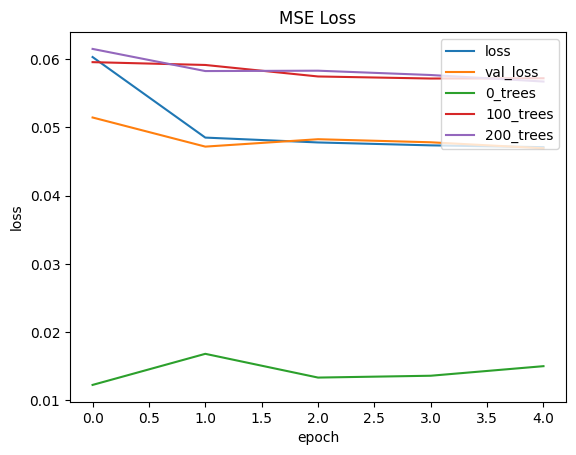

In [27]:
# Load best model weights if any weights have been stored
#model.load_weights(checkpoint_filepath)

# train on the dataset
history = model.fit(
    x=train_data,
    epochs=5,
    use_multiprocessing=True,
    validation_data=validation_data,
    callbacks=callbacks,
    shuffle=True
)

for metric in history.history.keys():
    plt.plot(history.history[metric], label=metric)

plt.title('MSE Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()